# Assignment 11 - Unsupervised Learning

1. Preprocess the customer data. How are you handling nulls? What process(es) are you using to encode and normalize the data?

In [12]:
import pandas as pd

customer_df = pd.read_csv('../Misc./customer_data.csv', encoding = 'unicode_escape')
customer_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [13]:
customer_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

After parsing through all the nulls in the "Description"—more appropriately titled "item sold"—column, it appears that for every missing value, the unit price is and Cusomter ID are likewise blank. This holds true no matter the month in question:

For example, let's compare a few such offenders, beginning with row 21779:

<538128,21357,,46,12/9/2010 15:54,0,,United Kingdom>

...row 131742:

<547626,20973,,60,3/24/2011 11:30,0,,United Kingdom>

...and row 319903:

<564920,48116,,8,8/31/2011 12:43,0,,United Kingdom>

As demonstrated by all the above cases, the third column "Description" is null, the sixth column "Unit Price" equal to 0, and the seventh column "Customer ID" null. Such a pattern maintains in every entry featuring nulls in its description: again, that's the item sold. Then, the prevailing question looms, what should be done with these nulls? Well, I'm hesitant to take the conventional route of replacing them with the mode or median of the dataset, for fear of skewing my models. Further, the only useful feature these data harbor for the incumbent K-means and hierarchical clustering approaches are their "quantity" column—the fourth, above—but, for lack of an item or price, the context of the quantity is all but meaningless. With that ample justification behind us, I'll take the perhaps contentious, but I believe appropriate step of deleting the rows of data with nulls in their description. To further assuage doubt, this represents 1454/541911 = 0.003% of the data.

In [14]:
customer_df_cleaned = customer_df.dropna(subset = ['Description'])
customer_df_cleaned.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

Nice!

As for the "CustomerID" column, those nulls won't actually be consequential to my modelling, given K-means and hierarchical clustering will attempt to categorize purchasers based on their orders. Including CustomerID would be including a perfect predictor of outcome, which defeats the entire purpose of unsupervised learning.

However, I can, and will, drop the spaces from the items in the "Description" column, then label encoding the column. Dropping the spaces is a preemptive measure to prevent the same items from being encoded differently, due to typographic differences when they were entered; as I've skimmed the dataset, there appears to be at least some variability to this end. Moreover, I'm chosing to label encode because no natural order exists among these items: they're all equally valid, for my models!

In [15]:
customer_df_cleaned['Description'] = customer_df_cleaned['Description'].apply(lambda x: x.replace(' ', ''))

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_56423/1238725550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_cleaned['Description'] = customer_df_cleaned['Description'].apply(lambda x: x.replace(' ', ''))


In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
customer_df_cleaned['Description_encoded'] = encoder.fit_transform(customer_df_cleaned['Description'])

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_56423/2566814681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_cleaned['Description_encoded'] = encoder.fit_transform(customer_df_cleaned['Description'])


And finally, normalization. To further my thesis from earlier, I'll only be considering a select few features for these models. Let's take a look at those available to us:

In [17]:
print(customer_df_cleaned.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Description_encoded'],
      dtype='object')


Ignoring the 4200-plus one-hot encoding columns we just created, it seems that a few features should certainly not be considered, for the same reason CustomerID wasn't, including InvoiceNo, StockCode, and InvoiceDate. From a practical perspective, these sorts of data would either provide our models the same degree of perfect prediction that CustomerID would've—such as InvoiceNo and StockCode—or simply be confounding, overfitting-prone information—such as InvoiceDate. Then, we are left with four features—Description, Quantity, UnitPrice, and Country—to plug into our unsupervised models. As one-hot encoding has already situated Description and Country for binary classification, the only two features left to normalize are Quantity and UnitPrice, a step which is rather important given these distance-based forms of classification.

In [18]:
from sklearn.preprocessing import StandardScaler

features_to_be_normalized = customer_df_cleaned[['Quantity', 'UnitPrice']]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_to_be_normalized)
customer_df_cleaned[['Quantity', 'UnitPrice']] = normalized_features

/var/folders/jq/xzwg3k5d0nqb3574ynkvzc740000gn/T/ipykernel_56423/79918219.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_cleaned[['Quantity', 'UnitPrice']] = normalized_features


2. Perform k-means on this dataset for customer segments. Customer segments help determine what types of people buy your product, which allows you to target more people like your usual customers. Should you look at all the data, or which subset of data should you use? What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

After crashing my kernel three times, I've come to the conclusion it would probably be wise to do a random sample of my data, for the K-means model. This should come as no surprise, given the data is—as I've mentioned—more than half a million rows long: I should've known better, but here we are!

In [19]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

# Dropping "Description", among the others, which is the categorical version of our new and improved "Description_encoded column":
X = customer_df_cleaned.drop(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'Country'], axis = 1)
y = customer_df_cleaned['Country']

X_sampled = X.sample(n = 10000, random_state = 32) # Let's try less than a tenth of the original sample size.
y_sampled = y.sample(n = 10000, random_state = 32)

inertias = []
distortions = []

for k in range(1, 10):
    model = KMeans(n_clusters = k).fit(X_sampled)

    distance = cdist(X_sampled, model.cluster_centers_, 'euclidean')
    distortion = sum(np.min(distance, axis = 1)) / X_sampled.shape[0]
    distortions.append(distortion)

    inertia = model.inertia_
    inertias.append(inertia)

Text(0.5, 1.0, 'Elbow Method with Distortion')

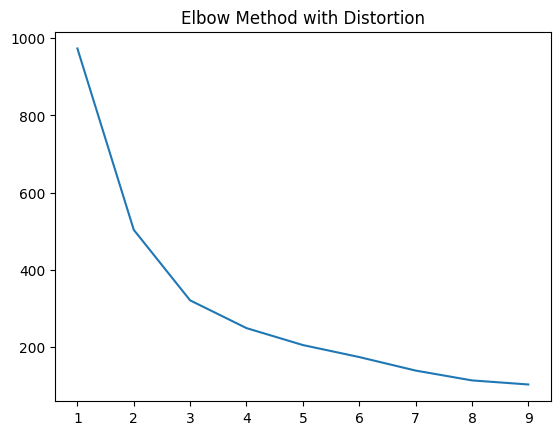

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1,10), distortions)
plt.title('Elbow Method with Distortion')

Text(0.5, 1.0, 'Elbow Method with Inertia')

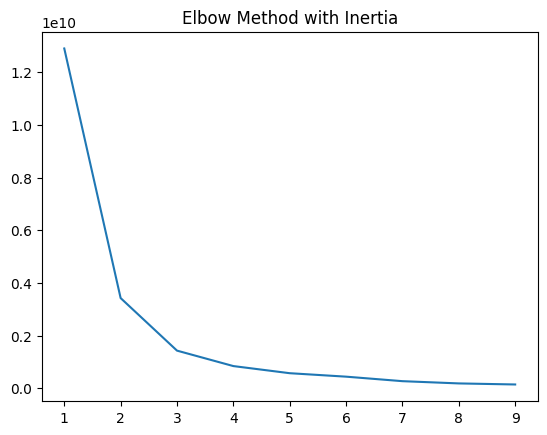

In [21]:
plt.plot(range(1,10), inertias)
plt.title('Elbow Method with Inertia')

After analyzing Distortion and Inertia, it appears the best number of clusters—K—is 3. As can be seen above, I first used "Distortion", or the average of the squared distances between points and their cluster center (in Euclidian space, in my case), then "Inertia"—or the distance between each data point and the centroid summed, then squared across each cluster. This model is the characteristic ideal describes in class, featuring both low—and aligning!—distortion AND inertia, and a low number of clusters.

3. Perform hierarchical clustering for customer segments. What is the ideal number of clusters? Which approach did you use to find the ideal number of clusters and why?

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkages = linkage(X_sampled, 'ward')
plt.figure(figsize = (10,7))
dendro = dendrogram(linkages, labels = list(y_sampled))

In [22]:
print("Shape of X_sampled:", X_sampled.shape)
print("Length of y:", len(y_sampled))

Shape of X_sampled: (10000, 3)
Length of y: 10000


4. Compare the results of 2 and 3. Which approach do you think is best? Why?